In [1]:
import numpy as np
from itertools import product

from ADAPTIVE_QAOA.adaptive_qaoa_src.Ansatz import *
import scipy as sc
from qiskit.visualization import plot_histogram

In [2]:
# Generating random graph 
n = 4
rng_seed = int(np.random.randint(0,2**31-1))
np.random.seed(rng_seed)
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
edge_list = generate_random_graph(nodes=n,weighted=True,w_min=1e-2,seed=rng_seed)

# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(edge_list)


Best solution = [0 1 0 1] cost = -2.4632


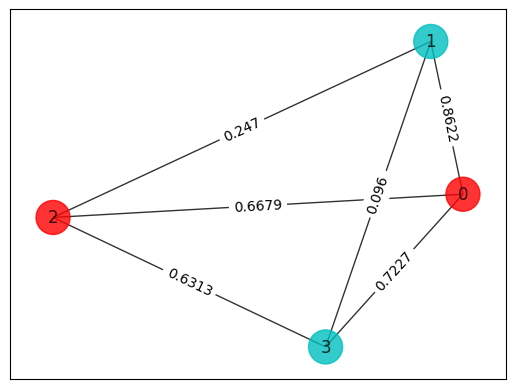

In [3]:
# Calculating optimal partition and plotting
best_cost, best_perm = qubo_min_cost_partition(nr_nodes=n,Q_mat=get_qubo(size=n,edges=edge_list))
colors = ["r" if best_perm[i] == 0 else "c" for i in range(n)]
print("\nBest solution = " + str(best_perm) + " cost = " + str(best_cost))
pos = nx.spring_layout(G)
draw_graph(G, colors, pos)


In [6]:
# Defining instance of QAOA ansatz
QAOA_objective = ADAPTIVEQAOAansatz(n_qubits=n,w_edges=edge_list, backend="SYMQ", precision=64)

In [7]:
# Number of repetitions of (cost, mixer) in circuit
layers=2

# Initial guess for parameters (beta, gamma) of circuit
np.random.seed(0)
theta_min, theta_max = -np.pi, np.pi
theta_i = np.random.uniform(low=theta_min, high=theta_max, size=2*layers)

# ------ Optimizer run ------ #

# Optimizer technique 1)
#_available_methods_ = ['Nelder-Mead', 'Powell', 'COBYLA', 'trust-constr']
#res = sc.optimize.minimize(fun=QAOA_objective.evaluate_circuit, x0=theta_i,method=_available_methods_[2])

# Optimizer technique 2)
#res = sc.optimize.basinhopping(func=QAOA_objective.evaluate_circuit, x0=theta_i, niter=10, stepsize=0.75)

# Optimizer technique 3)
#_available_strategies_ = ['best1bin', 'best1exp', 'rand1exp', 'randtobest1exp', 'currenttobest1exp', 'best2exp', 'rand2exp', 'randtobest1bin', 'currenttobest1bin', 'best2bin', 'rand2bin', 'rand1bin']
#res = sc.optimize.differential_evolution(func=QAOA_objective.evaluate_circuit,bounds=[(theta_min, theta_max) for angle in theta_i], strategy=_available_strategies_[1],popsize=2, maxiter=50)

# Optimizer technique 4)
_available_sampling_methods_ = ['simplicial', 'halton', 'sobol']
res = sc.optimize.shgo(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], sampling_method=_available_sampling_methods_[2])

# Optimizer technique 5)
#res = sc.optimize.dual_annealing(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], maxfun=1000)

# Optimizer technique 6)
#res = sc.optimize.direct(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], maxfun=400)

# Final parameters (beta, gamma) for circuit
theta_f = res.x.tolist()
res

/Users/sebastianyde/miniforge3/lib/python3.10/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


     fun: -1.960668724109581
    funl: array([-1.96066872, -1.74951678, -1.55690334, -1.5225154 , -1.30026198])
 message: 'Optimization terminated successfully.'
    nfev: 288
     nit: 2
   nlfev: 160
   nlhev: 0
   nljev: 14
 success: True
       x: array([ 2.35696148,  2.35696148, -2.35696148, -0.7815632 ])
      xl: array([[ 2.35696148,  2.35696148, -2.35696148, -0.7815632 ],
       [ 0.04588474, -2.11377464, -2.79285073, -2.30341956],
       [-2.92782214,  0.19231875,  2.54317272,  2.94619998],
       [ 0.78539816, -2.35619449,  2.35619449,  0.78539816],
       [-2.84706834, -1.47262156,  1.27627202,  0.29452431]])

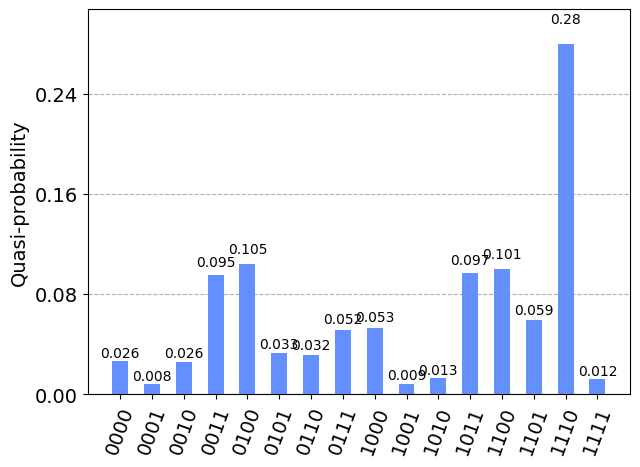

In [9]:
QAOA_objective.set_circuit(theta=theta_f)
plot_histogram(QAOA_objective.current_circuit.get_state_probabilities(reverse_states=True))